# 1Epochs/static="features" Explore the predictions of runoff model 
NOTE: only 13 stations were used for this analysis because the static data introduced too many nans! 

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [4]:
EXPERIMENT =      'one_timestep_forecast_19epoch_static'
TRUE_EXPERIMENT = 'one_timestep_forecast'
TARGET_VAR =      'discharge_vol'

assert (data_dir / f"models/{EXPERIMENT}").exists()
assert (data_dir / f"features/{TRUE_EXPERIMENT}").exists()

# Read in the data

In [5]:
lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)
lstm_pred = lstm_pred.rename({'spatial_unit': 'station_id'})
lstm_pred

Reading all .nc files from: data/models/one_timestep_forecast_19epoch_static/rnn
All datasets loaded. Now combining ...


<xarray.Dataset>
Dimensions:     (station_id: 662, time: 1734)
Coordinates:
  * station_id  (station_id) object '10002' '10003' '1001' ... '96004' '97002'
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-09-30
Data variables:
    preds       (time, station_id) float32 15.705349 21.202293 ... 3.1970673

In [6]:
# LET'S ZERO the values below zero

[<matplotlib.lines.Line2D at 0x7fdc56538450>]

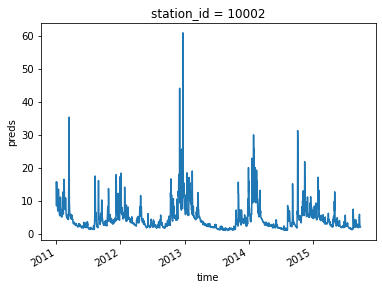

In [7]:
fig, ax = plt.subplots()
lstm_pred.preds.isel(station_id=0).plot(ax=ax)

# Read in the True data

In [8]:
ds = xr.open_dataset(data_dir / 'interim__/camels_preprocessed/data.nc')

# get the times that match
min_time = lstm_pred.time.min().values
max_time = lstm_pred.time.max().values
y_test = ds.discharge_vol.sel(time=slice(min_time, max_time))

In [9]:
y_test

<xarray.DataArray 'discharge_vol' (time: 1734, station_id: 671)>
[1163514 values with dtype=float64]
Coordinates:
  * station_id  (station_id) object '55008' '54027' '102001' ... '54095' '97002'
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-09-30

In [10]:
# get the stations that match
y_test = y_test.sel(
    station_id=y_test.station_id[
        np.isin(y_test.station_id, lstm_pred.station_id)
    ]
)

In [11]:
y_test

<xarray.DataArray 'discharge_vol' (time: 1734, station_id: 662)>
[1147908 values with dtype=float64]
Coordinates:
  * station_id  (station_id) object '54027' '102001' '72005' ... '54095' '97002'
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-09-30

In [47]:
df.head()

,station_id,discharge_vol,preds
time,,,
2011-01-01,10002,13.77,15.705349
2011-01-02,10002,10.40,11.305079
2011-01-03,10002,12.15,8.594060
2011-01-04,10002,12.52,15.787477
2011-01-05,10002,10.11,10.200069


# compare performance

In [12]:
from src.analysis.evaluation import (r2_score, rmse, spatial_rmse, spatial_r2, spatial_nse) 
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse

In [13]:
# calculate performance for each station (collapse time)
rmse_da = spatial_rmse(y_test, lstm_pred.preds)
r2_da = spatial_r2(y_test, lstm_pred.preds)
nse_da = spatial_nse(y_test, lstm_pred.preds)

In [14]:
# calculate performance for each station (collapse space)
rmse_time = temporal_rmse(y_test, lstm_pred.preds)
r2_time = temporal_r2(y_test, lstm_pred.preds)
nse_time = temporal_nse(y_test, lstm_pred.preds)

In [15]:
print(f"Mean Station RMSE: {rmse_da.mean().values:.2f}")
print(f"Mean Station NSE: {nse_da.mean().values:.2f}")
print(f"Mean Station R2: {r2_da.mean().values:.2f}")

print(f"\n\nMean Time RMSE: {rmse_time.mean().values:.2f}")
print(f"Mean Time NSE: {nse_time.mean().values:.2f}")
print(f"Mean Time R2: {r2_time.mean().values:.2f}")

Mean Station RMSE: 4.11
Mean Station NSE: -0.19
Mean Station R2: 0.88


Mean Time RMSE: 4.63
Mean Time NSE: 0.94
Mean Time R2: 0.94


In [16]:
true_da = y_test
pred_da = lstm_pred.preds

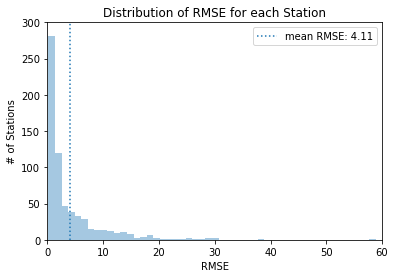

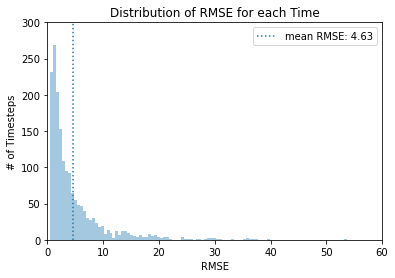

In [17]:
xlim = [0, 60]
ylim = [0, 300]

fig, ax = plt.subplots()
sns.distplot(rmse_da.values, ax=ax, kde=False) #, bins=10)
ax.set_title('Distribution of RMSE for each Station')
ax.set_ylabel('# of Stations')
ax.set_xlabel('RMSE');
ax.axvline(rmse_da.mean(), ls=":", label=f'mean RMSE: {rmse_da.mean().values:.2f}')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.legend()

fig, ax = plt.subplots()
sns.distplot(rmse_time.values, ax=ax, kde=False, bins=100)
ax.set_title('Distribution of RMSE for each Time')
ax.set_ylabel('# of Timesteps')
ax.set_xlabel('RMSE');
ax.axvline(rmse_time.mean(), ls=":", label=f'mean RMSE: {rmse_time.mean().values:.2f}')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.legend()

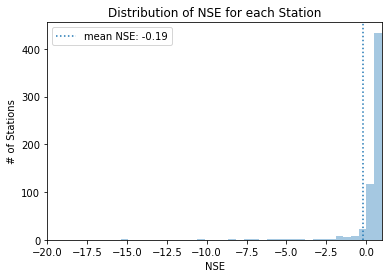

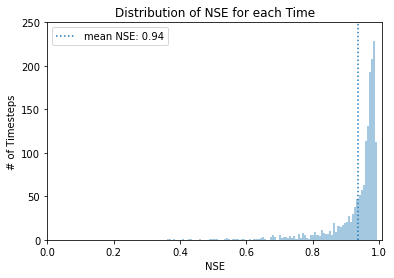

In [18]:
xlim = [0, 1.01]
ylim = [0, 250]

fig, ax = plt.subplots()
sns.distplot(drop_nans_and_flatten(nse_da), ax=ax, kde=False, bins=400)
ax.set_title('Distribution of NSE for each Station')
ax.set_ylabel('# of Stations')
ax.set_xlabel('NSE');
ax.axvline(nse_da.mean(), ls=":", label=f'mean NSE: {nse_da.mean().values:.2f}')
ax.set_xlim([-20, 1])
# ax.set_ylim(ylim)
plt.legend()

fig, ax = plt.subplots()
sns.distplot(drop_nans_and_flatten(nse_time), ax=ax, kde=False, bins=100)
ax.set_title('Distribution of NSE for each Time')
ax.set_ylabel('# of Timesteps')
ax.set_xlabel('NSE');
ax.axvline(nse_time.mean(), ls=":", label=f'mean NSE: {nse_time.mean().values:.2f}')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.legend()

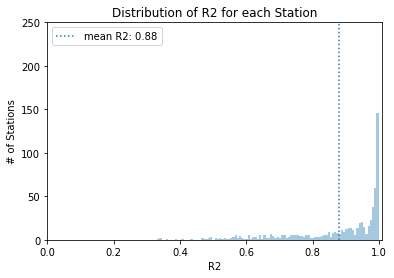

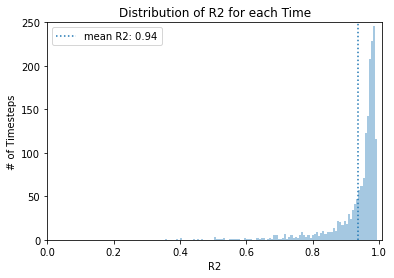

In [19]:
xlim = [0, 1.01]
ylim = [0, 250]

fig, ax = plt.subplots()
sns.distplot(r2_da.values, ax=ax, kde=False, bins=100)
ax.set_title('Distribution of R2 for each Station')
ax.set_ylabel('# of Stations')
ax.set_xlabel('R2');
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.axvline(r2_da.mean(), ls=":", label=f'mean R2: {r2_da.mean().values:.2f}')
plt.legend()


fig, ax = plt.subplots()
sns.distplot(r2_time.values, ax=ax, kde=False, bins=100)
ax.set_title('Distribution of R2 for each Time')
ax.set_ylabel('# of Timesteps')
ax.set_xlabel('R2');
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.axvline(r2_time.mean(), ls=":", label=f'mean R2: {r2_time.mean().values:.2f}')
plt.legend()


Text(0.5, 1.0, 'Moving 3M Performance [RMSE]')

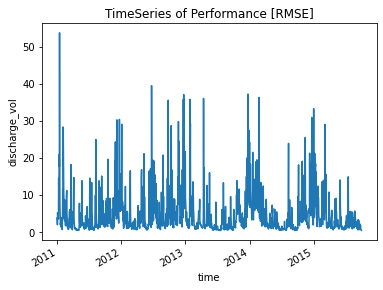

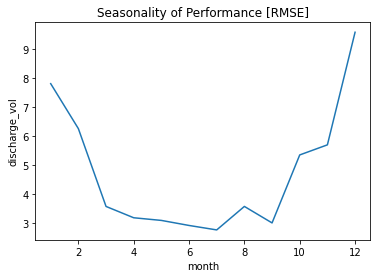

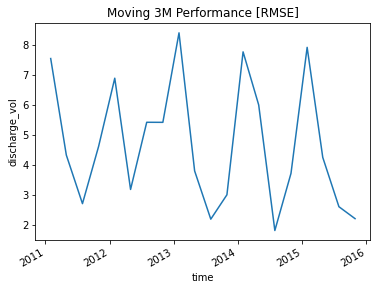

In [20]:
fig, ax = plt.subplots()
rmse_time.plot(ax=ax)
ax.set_title('TimeSeries of Performance [RMSE]')

fig, ax = plt.subplots()
rmse_time.groupby('time.month').mean().plot(ax=ax)
ax.set_title('Seasonality of Performance [RMSE]')

fig, ax = plt.subplots()
rmse_time.resample(time='3M').mean().plot(ax=ax)
ax.set_title('Moving 3M Performance [RMSE]')

Text(0.5, 1.0, 'Moving 3M Performance [NSE]')

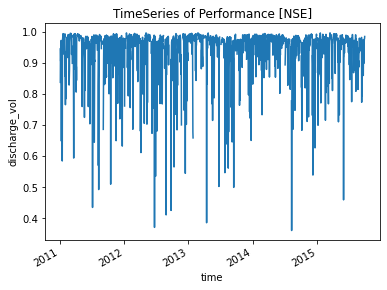

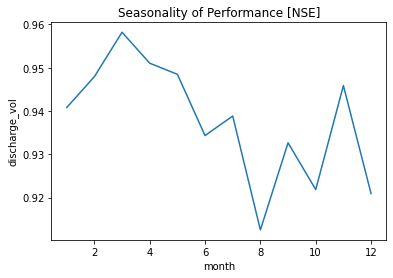

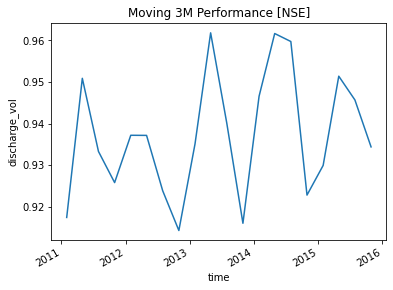

In [21]:
fig, ax = plt.subplots()
nse_time.plot(ax=ax)
ax.set_title('TimeSeries of Performance [NSE]')

fig, ax = plt.subplots()
nse_time.groupby('time.month').mean().plot(ax=ax)
ax.set_title('Seasonality of Performance [NSE]')

fig, ax = plt.subplots()
nse_time.resample(time='3M').mean().plot(ax=ax)
ax.set_title('Moving 3M Performance [NSE]')

Text(0.5, 1.0, 'Moving 3M Performance [R2]')

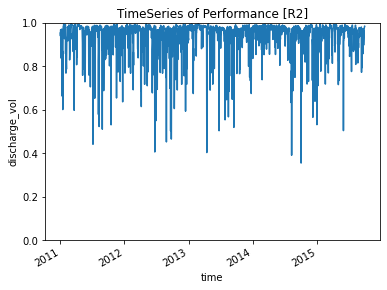

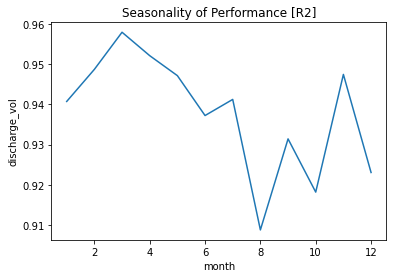

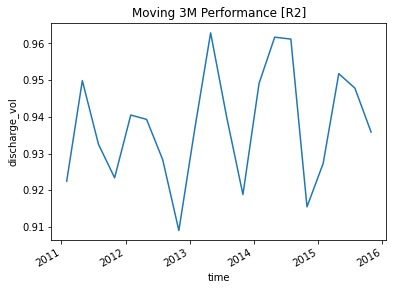

In [22]:
fig, ax = plt.subplots()
r2_time.plot(ax=ax)
ax.set_title('TimeSeries of Performance [R2]')
ax.set_ylim(0, 1)

fig, ax = plt.subplots()
r2_time.groupby('time.month').mean().plot(ax=ax)
ax.set_title('Seasonality of Performance [R2]')

fig, ax = plt.subplots()
r2_time.resample(time='3M').mean().plot(ax=ax)
ax.set_title('Moving 3M Performance [R2]')


In [23]:
from src.analysis.evaluation import join_true_pred_da

In [24]:
df = (
    join_true_pred_da(true_da, pred_da)
    .to_dataframe()
    .reset_index()
    .set_index('time')
)
df.head()

,station_id,discharge_vol,preds
time,,,
2011-01-01,10002,13.77,15.705349
2011-01-02,10002,10.40,11.305079
2011-01-03,10002,12.15,8.594060
2011-01-04,10002,12.52,15.787477
2011-01-05,10002,10.11,10.200069


In [25]:
# rmse and r2 df
metrics_df = rmse_da.to_dataframe().drop(columns='time').rename(columns={"preds": "rmse"}).join(
    r2_da.to_dataframe().drop(columns='time').rename(columns={"preds": "r2"})
)
metrics_df = metrics_df.join(
    nse_da.to_dataframe().rename(columns={"preds": "nse"})
)

metrics_df = metrics_df.reset_index()
metrics_df.head()

,station_id,rmse,r2,nse
0,10002,1.682677,0.907781,0.860602
1,10003,2.047791,0.891958,0.891548
2,1001,1.820344,0.916518,0.758656
3,101002,0.529018,0.995155,-0.613890
4,101005,0.381545,0.997567,0.037281


## Compare with the other models

In [96]:
def plot_station_scatter(
    df: pd.DataFrame, station_id: str, metrics_df: Optional[pd.DataFrame] = None, ax=None
):
    d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = plt.gcf()
    
    # plot scatter
    ax.plot(d.discharge_vol, d.preds, 'kx', alpha=0.6, label='Data Point')
    # plot 1:1 line
    
#     xy_line = (d.discharge_vol.max(), d.preds.max())
#     ax.plot(xy_line, 'k--', label='1:1 Line')

    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    ax.set_title(f'Station {station_id}')

    plt.legend();
    
    if False:
        # making the plot pretty
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                          + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig, ax

# how to automatically annotate? hard
# ax.annotate('Over Predict', xy=(0.3, 0.3), xytext=(0.7, 1.05),
#             ha='center', va='center');
# ax.annotate('Under Predict', xy=(0.7, 0.3), xytext=(0.7, 0.2),
#             ha='center', va='center');

In [97]:
station_id

'83010'

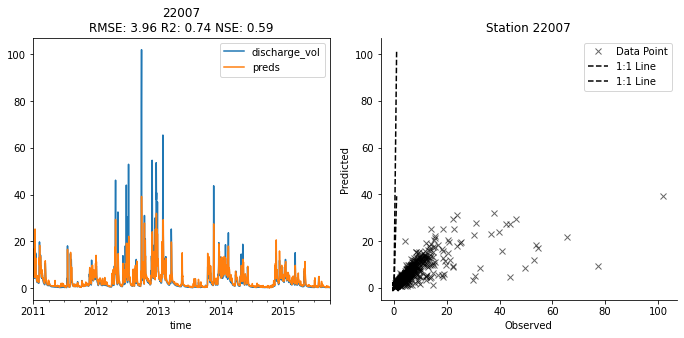

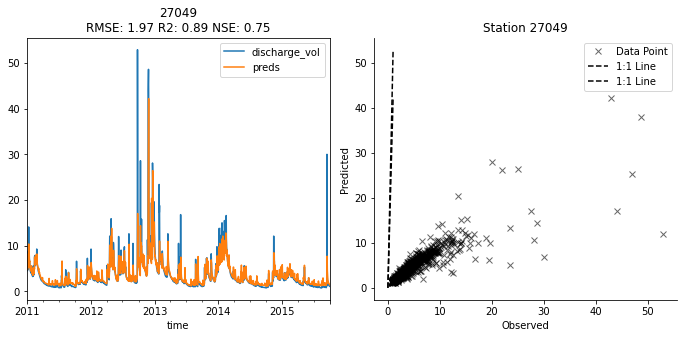

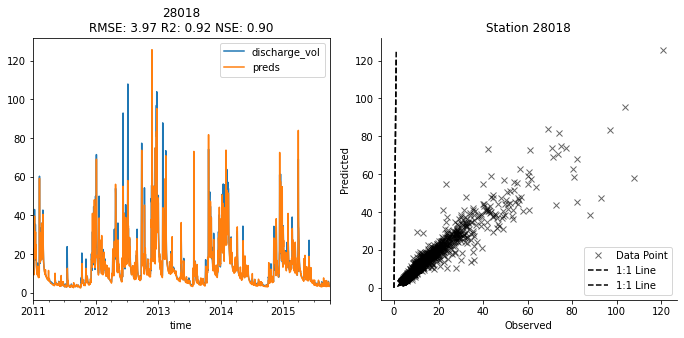

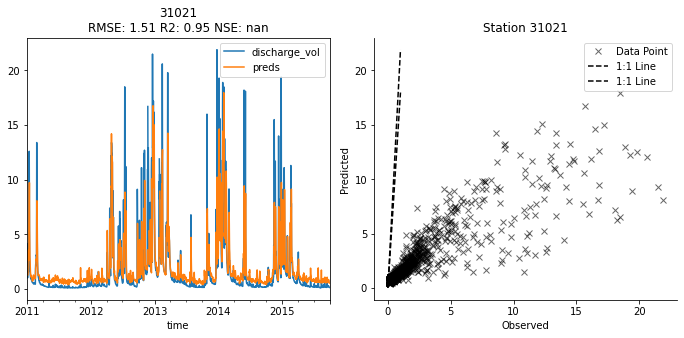

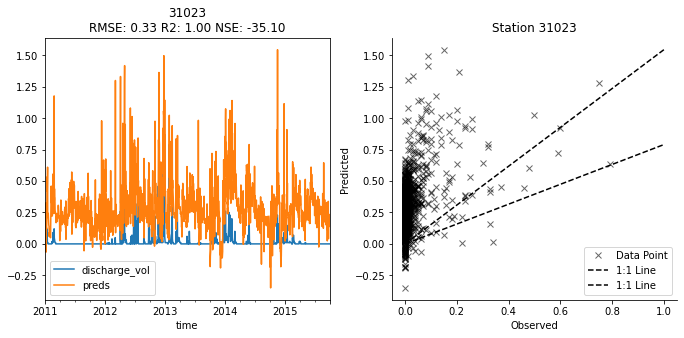

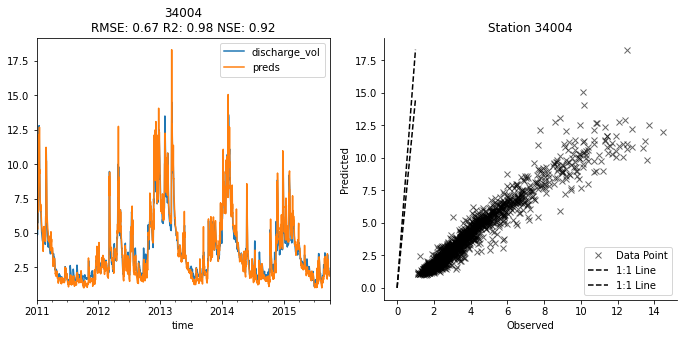

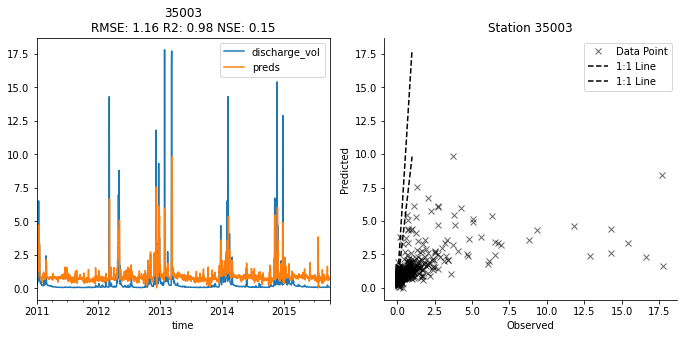

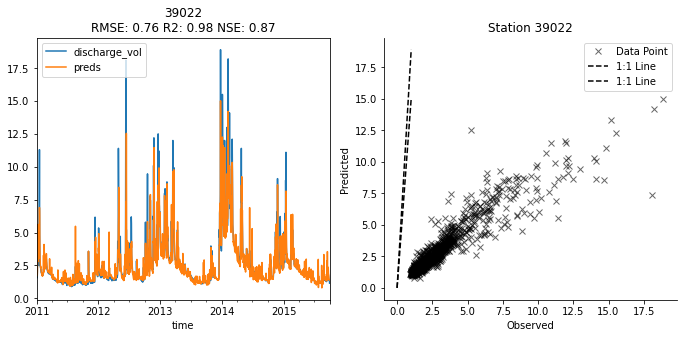

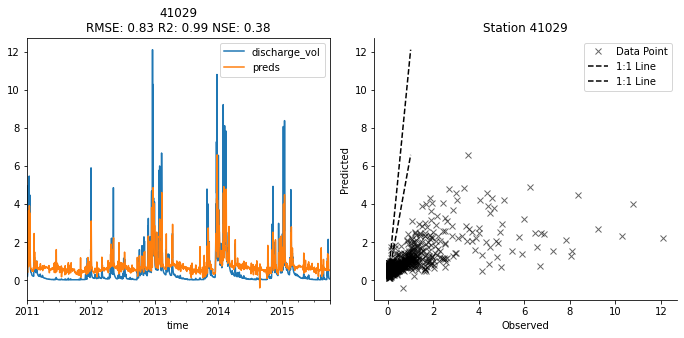

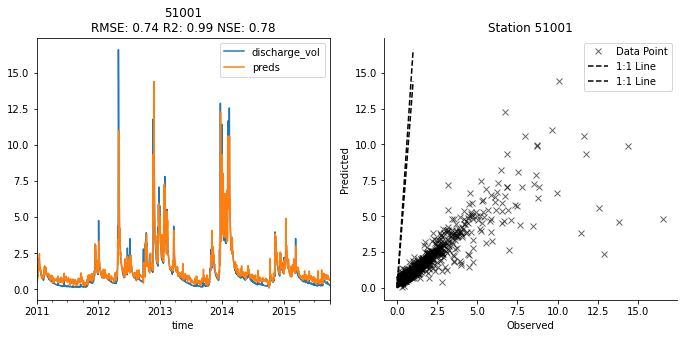

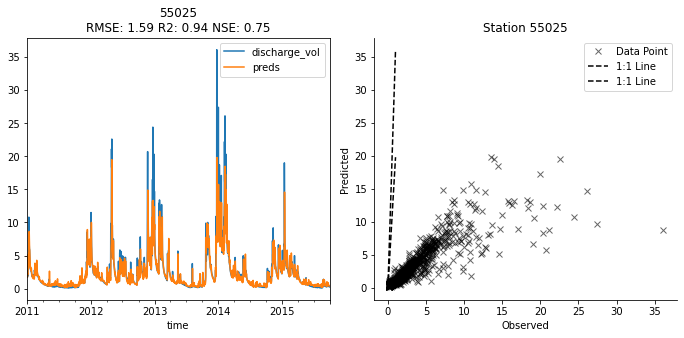

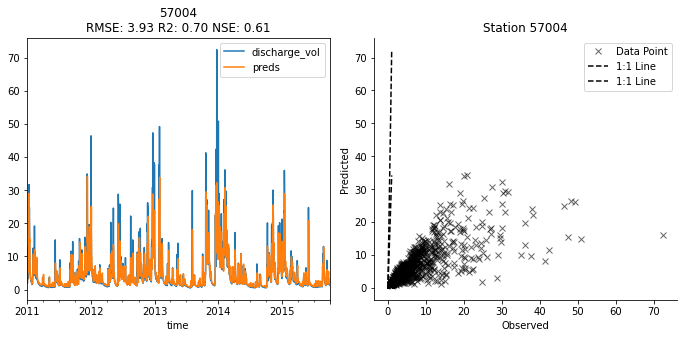

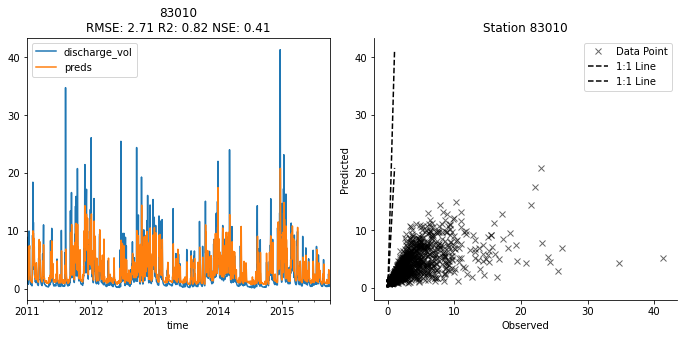

In [98]:
test_stations = ['22007', '27049', '28018', '31021', '31023', '34004', '35003', '39022', '41029', '51001', '55025', '57004', '83010']


def plot_station(df: pd.DataFrame, station_id: str, metrics_df: Optional[pd.DataFrame] = None, ax=None):
    """"""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    df.query(f"station_id == '{station_id}'").drop(columns='station_id').plot(ax=ax)
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    ax.set_title(f"{station_id}\nRMSE: {rmse_val:.2f} R2: {r2_val:.2f} NSE: {nse_val:.2f}")
    return fig, ax


scale = 0.8
for station_id in test_stations:
    fig, axs = plt.subplots(1, 2, figsize=(12*scale, 6*scale))
    plot_station(df, station_id, metrics_df, ax=axs[0])
    plot_station_scatter(df, station_id, metrics_df, axs[1])
    plt.tight_layout()

# TODO:
- how to enforce a hard zero on predictions
- e.g. station 31023
- still missing the peaks of the distribution !!
- something to do with baseflow (?)

# Let's look at station 31023


In [34]:
station_id = "31023"
station_df = df.query(f"station_id == '{station_id}'")

# floor values (if below 0 -> 0)
station_floored = station_df.copy()
station_floored.loc[station_floored.preds < 0, "preds"] = 0

In [35]:
from src.analysis.evaluation import _r2_func, _rmse_func, _nse_func

_rmse_func(station_df.discharge_vol, station_df.preds, len(station_df))
_r2_func(station_df.discharge_vol, station_df.preds)
_nse_func(station_df.discharge_vol, station_df.preds)

-35.09732202003378

In [36]:
def pd_rmse(preds: pd.Series, obs: pd.Series) -> float:
    return ((obs - preds) ** 2).mean() ** .5

def pd_r2(preds: pd.Series, obs: pd.Series) -> float:
    return _r2_func

print(pd_rmse(station_df.preds, station_df.discharge_vol))
print(pd_rmse(station_floored.preds, station_df.discharge_vol))

0.3269141551230439
0.3264723316333263


### Raw values plotted

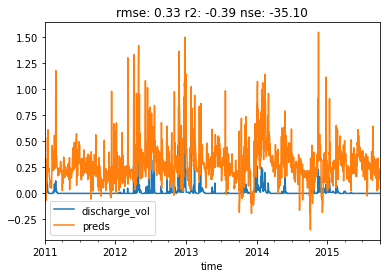

In [37]:
fig, ax = plt.subplots()
station_df.plot(ax=ax);
rmse_val = _rmse_func(station_df.discharge_vol, station_df.preds, len(station_df))
r2_val = _r2_func(station_df.discharge_vol, station_df.preds)
nse_val = _nse_func(station_df.discharge_vol, station_df.preds)

ax.set_title(f"rmse: {rmse_val:.2f} r2: {r2_val:.2f} nse: {nse_val:.2f}");

### What happens if we set the values below 0 -> 0

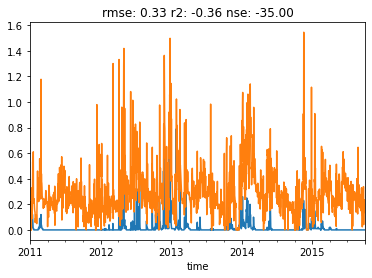

In [38]:
station_id = "31023"
station_df = df.query(f"station_id == '{station_id}'")
fig, ax = plt.subplots()
station_df.discharge_vol.plot(ax=ax);

# floor values
station_floored = station_df.copy()
station_floored.loc[station_floored.preds < 0, "preds"] = 0
station_floored.preds.plot(ax=ax)

rmse_val = _rmse_func(station_df.discharge_vol, station_floored.preds, len(station_df))
r2_val = _r2_func(station_df.discharge_vol, station_floored.preds)
nse_val = _nse_func(station_df.discharge_vol, station_floored.preds)

ax.set_title(f"rmse: {rmse_val:.2f} r2: {r2_val:.2f} nse: {nse_val:.2f}");

# Top 10 stations

In [39]:
# rmse_da; nse_da; r2_da

def get_n_hilo_values(da: xr.DataArray, n_values: int, hilo: str = 'high', coord: Optional[str] = None) -> xr.DataArray:
    assert hilo in ['high', 'low'], "only high / low are valid options for top/bottom n"

    coord = [c for c in da.coords][0] if coord is None else coord
    sorted_da = da.sortby(da).where(~da.isnull(), drop=True)
    if hilo == 'low':
        return sorted_da.isel({coord: slice(0, 10)})
    elif hilo == 'high':
        return sorted_da.isel({coord: np.arange(-10, 0)})
    else:
        assert False
    
top_10 = get_n_hilo_values(nse_da, 10, hilo='high')
bottom_10 = get_n_hilo_values(nse_da, 10, hilo='low')

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(16, 18), sharex=True, sharey=True)

for ix, station_id in enumerate(top_10.station_id.values):
    ax = axs[np.unravel_index(ix, (5, 2))]
    plot_station(df, station_id=station_id, metrics_df=metrics_df, ax=ax)

fig.suptitle('Top 10 Basins by NSE', y=0.98, size=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(16, 18), sharex=True, sharey=True)

for ix, station_id in enumerate(bottom_10.station_id.values):
    ax = axs[np.unravel_index(ix, (5, 2))]
    plot_station(df, station_id=station_id, metrics_df=metrics_df, ax=ax)

fig.suptitle('Bottom 10 Basins by NSE', y=0.98, size=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])

# What data was used for training?

## look at the static data

In [41]:
from src.models import load_model

lstm = load_model(data_dir / f"models/{EXPERIMENT}/rnn/model.pt")

In [42]:
dl = lstm.get_dataloader(mode='train')
train_iter = iter(dl)
static_ds = train_iter.static
# [v for v in static_ds.data_vars]

In [44]:
# static_ds

### Extract features for top10 / bottom10

In [ ]:
# static_ds.sel(station_id=)

# static_ds.loc[dict(station_id=np.isin(static_ds.station_id.values, bottom_10.station_id.values.astype(int)))]
def get_station_data(ds: xr.Dataset, station_ids: List[int]) -> xr.Dataset:
    return ds.sel(station_id=np.isin(ds.station_id.values, station_ids))

# static_ds.sel(station_id=np.isin(static_ds.station_id.values, bottom_10.station_id.values.astype(int)))

static_bottom = get_station_data(static_ds, bottom_10.station_id.values.astype(int))
dynamic_bottom = get_station_data(ds.drop(lstm.ignore_vars), bottom_10.station_id.values.astype(int))
static_top = get_station_data(static_ds, top_10.station_id.values.astype(int))
dynamic_top = get_station_data(ds.drop(lstm.ignore_vars), top_10.station_id.values.astype(int))

In [ ]:
# static_top.mean().to_dataframe()

def convert_mean_vals_to_dataframe(ds) -> pd.DataFrame:
    data_dict = {}
    for k in ds.mean().to_dict()['data_vars'].keys():
        data = ds.mean().to_dict()['data_vars'][k]['data']
        data_dict[k] = data

    return pd.DataFrame(data_dict, index=[0]).melt()


def get_top_bottom_df(top_ds, bottom_ds) -> pd.DataFrame:
    df1 = convert_mean_vals_to_dataframe(bottom_ds).rename(columns={'value': 'bottom 10'}).set_index('variable')
    df2 = convert_mean_vals_to_dataframe(top_ds).rename(columns={'value': 'top 10'}).set_index('variable')
    return df1.join(df2)

df_static = get_top_bottom_df(top_ds=static_top, bottom_ds=static_bottom)
df_static.head()

In [ ]:
df_static['bottom 10'] - df_static['top 10']

In [ ]:
# NORMALIZE
df_static['bottom 10'] = df_static['bottom 10'] / df_static.max(axis=1)
df_static['top 10'] = df_static['top 10'] / df_static.max(axis=1)
df_static['diff'] = abs(df_static['bottom 10'] - df_static['top 10'])
df_static = df_static.sort_values('diff')
df_static.tail()

In [ ]:

fig, ax = plt.subplots(figsize=(12, 5))
df_static.plot.bar(ax=ax)

In [ ]:
# df_dynamic = get_top_bottom_df(top_ds=dynamic_top.load(), bottom_ds=dynamic_bottom.load())

## And the Dynamic data?

In [ ]:
print(lstm.ignore_vars)
ds.drop(lstm.ignore_vars).data_vars